In [0]:
import numpy as np
import nltk
from zipfile import ZipFile
from nltk.tokenize import TreebankWordTokenizer
import pickle
import random
from itertools import combinations
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from pathlib import Path

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def random_seed(value):
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Load the data

In [0]:
#!wget https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip

In [0]:
with ZipFile("data2.zip", 'r') as zip_ref:
    zip_ref.extractall('data')

In [9]:
raw_documents = []
snippets = []
with open( "data/data.txt", "r") as f:
    for line in f.readlines():
        text = line.strip()
        raw_documents.append( text.lower() )
        
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))


# custom stopwords
custom_stop_words = []
with open( "data/stopwords.txt", "r" ) as f:
    for line in f.readlines():
        custom_stop_words.append( line.strip().lower() )
        
print("Stopword list has %d entries" % len(custom_stop_words) )

Read 4551 raw text documents
Stopword list has 350 entries


# Some preprocessing

In [0]:
tokenizer = TreebankWordTokenizer()
dataset = [tokenizer.tokenize(x) for x in raw_documents]

if not Path('vocab.pickle').exists():
    vocab_freq = {}
    for doc in dataset:
        for word in doc:
            if word in vocab_freq:
                vocab_freq[word] += 1
            else:
                vocab_freq[word] = 1
else:
    with open('vocab.pickle', 'rb') as f:
        vocab_freq = pickle.load(f)

In [0]:
vocab_list = [k for k, v in vocab_freq.items() if v > 50]

In [0]:
tokenizer = TreebankWordTokenizer()
dataset = [tokenizer.tokenize(x) for x in raw_documents]
for i, doc in enumerate(dataset):
    dataset[i] = list(filter(lambda x: x in vocab_list and x not in custom_stop_words, doc))

# Load pretrained embeddings

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-03-21 19:57:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-03-21 19:57:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-03-21 19:57:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

if not Path('emb_word2vec_format.txt').exists():
    glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="emb_word2vec_format.txt")

model = gensim.models.KeyedVectors.load_word2vec_format('emb_word2vec_format.txt')
weights = torch.FloatTensor(model.vectors)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
word2idx = {k:i for i, k in enumerate(model.vocab.keys())}
weight = np.array([model[k] for _, k in enumerate(model.vocab.keys())])

# Create dataset

In [0]:
encode = lambda x: word2idx[x] if x in model.vocab.keys() else word2idx['unk']
dataset = [[encode(x) for x in y] for y in dataset]

In [0]:
dataset = dataset + [[encode(x)] for x in vocab_list]

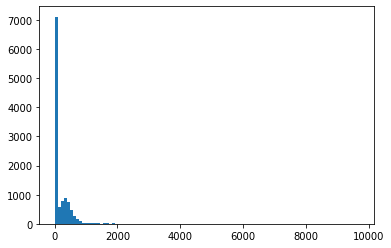

In [18]:
from matplotlib import pyplot as plt

plt.hist([len(x) for x in dataset], bins=100)
plt.show()

In [19]:
print(len(dataset))
print(len(list(filter(lambda x: len(x) < 1024, dataset))))

11439
11166


In [0]:
max_len = 512
tensor_dataset = []
for doc in dataset:
    tensor_dataset.append(torch.LongTensor(doc[:max_len]+(max_len - len(doc))*[encode('pad')]))

In [0]:
padding_idx = word2idx['pad']

# Batch sampler

In [0]:
class DataSampler():
    def __init__(self, dataset, negative_size=10, batch_size=5):
        self.dataset = random.sample(dataset, len(dataset))
        self.negative_size = negative_size
        self.batch_size = batch_size
        self.cur_idx = 0
        self.seed = 0 

    def __next__(self):
        batch = {'positive': [], 'negative': []}
        for j in range(self.batch_size):
            positive = self.dataset[self.cur_idx]
            rest = self.dataset[:self.batch_size*self.cur_idx+j] + self.dataset[self.batch_size*self.cur_idx+j+1:]
            random.seed(self.seed + j)
            negative = torch.stack(random.sample(rest, self.negative_size), 0)
            batch['positive'].append(positive)
            batch['negative'].append(negative)
        batch['positive'] = torch.stack(batch['positive'], 0)
        batch['negative'] = torch.stack(batch['negative'], 0)
          
        return batch

    def __iter__(self):
        self.cur_idx = 0
        for i in range(len(self.dataset) // self.batch_size):
            self.cur_idx += 1
            self.seed = i * self.batch_size
            yield self.__next__()

    def __len__(self):
        return len(self.dataset) // self.batch_size

# Model

In [0]:
class TopicModel(nn.Module):
    def __init__(self, vocab_size, d, n_topics):
        super().__init__()
        self.vocab_size = vocab_size
        self.d = d
        self.embedding = nn.Embedding(self.vocab_size, d)
        self.M_matrix = nn.Linear(d, d, bias=False)
        self.proj = nn.Linear(d, n_topics)

        self.T_matrix = nn.Parameter(nn.init.xavier_uniform_(torch.empty(n_topics, d)))

    def load_embedding_weight(self, weight, padding_idx=None, freeze=False):
        self.embedding = nn.Embedding(self.vocab_size, self.d).from_pretrained(weight, padding_idx=padding_idx)
        if freeze == True:
            self.embedding.requires_grad = False

    def forward(self, batch):
        pos_emb = self.embedding(batch['positive'])
        neg_context_emb = self.embedding(batch['negative']).mean(2)

        sent_context = pos_emb.mean(1)
        transf_emb = self.M_matrix(pos_emb)
        sim = torch.einsum('ble,be->bl', transf_emb, sent_context)
        alphas = F.softmax(sim, -1)
        attn = torch.einsum('ble,bl->be', pos_emb, alphas)
        p = F.softmax(self.proj(attn), -1)
        r = p @ self.T_matrix
        
        pos = torch.einsum('be,be->b', r, attn)
        neg = torch.einsum('be,bme->bm', r, neg_context_emb)

        return pos, neg 
    
    def get_probs(self, inp):
        pos_emb = self.embedding(inp)

        sent_context = pos_emb.mean(0)
        transf_emb = self.M_matrix(pos_emb)
        sim = torch.einsum('le,e->l', transf_emb, sent_context)
        alphas = F.softmax(sim, -1)
        attn = torch.einsum('le,l->e', pos_emb, alphas)
        p = F.softmax(self.proj(attn))

        return p

# Training

In [0]:
n_epoch = 15
batch_size = 10
negative_size = 20
lamda = 1

In [0]:
n_topics_range = [3, 4, 5, 6, 7, 8, 9, 10]
topic_models = []

In [49]:
for n_topics in n_topics_range:
    print(f'{n_topics} topics \n')
    random_seed(999)
    topic_model = TopicModel(len(word2idx), 300, n_topics=n_topics)
    topic_model.load_embedding_weight(torch.FloatTensor(weight), padding_idx=padding_idx, freeze=True)
    topic_model.to(device)
    optimizer = Adam(topic_model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

    def topic_loss_function(pos, neg, model):
        pos = pos.unsqueeze(-1)
        delta = 1 - pos + neg
        delta = F.relu(delta)
        reg = torch.frobenius_norm(model.T_matrix @ model.T_matrix.permute(1,0)  - torch.eye(n_topics).to(pos.device))
        loss = delta.sum() / batch_size + lamda * reg / len(sampler) / batch_size
        return loss

    topic_model.train()
    for ep in range(n_epoch):
        ep_loss = 0
        sampler = DataSampler(tensor_dataset, negative_size=negative_size, batch_size=batch_size)
        for step, batch in enumerate(iter(sampler)):
            for k, v in batch.items():
                batch[k] = v.to(device)
            optimizer.zero_grad()
            pos, neg = topic_model(batch)
            loss = topic_loss_function(pos, neg, topic_model)
            loss.backward()
            optimizer.step()
            ep_loss += loss.item()
        scheduler.step(ep_loss)
        print(f'Epoch {ep}, loss {ep_loss / len(sampler)}')

    topic_model.eval()
    with torch.no_grad():
        W = []
        for x in tensor_dataset:
            W.append(topic_model.get_probs(x.to(device)).cpu().numpy())
        W = np.array(W)

        H = []
        for x in vocab_list:
            if x not in word2idx.keys():
                continue
            H.append(topic_model.get_probs(torch.tensor([word2idx[x]]).to(device)).cpu().numpy())
        H = np.array(H)
        H = H.transpose()

    topic_models.append((n_topics, W, H))

3 topics 

Epoch 0, loss 1.1834207667004717
Epoch 1, loss 0.327033816035235
Epoch 2, loss 0.10593561906500354
Epoch 3, loss 0.04254377763309945
Epoch 4, loss 0.014832768478444659
Epoch 5, loss 0.005192565622978639
Epoch 6, loss 0.002252294764363501
Epoch 7, loss 0.001550640515479555
Epoch 8, loss 0.0013125151410464226
Epoch 9, loss 0.0014198245541767029
Epoch 10, loss 0.0016580137072989842
Epoch 11, loss 0.0014127142836762657
Epoch 12, loss 0.001256457536174954
Epoch 13, loss 0.0012029627925119089
Epoch 14, loss 0.001464898186232259


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


4 topics 

Epoch 0, loss 1.3867467337331045
Epoch 1, loss 0.38208580567142053
Epoch 2, loss 0.12283563132219388
Epoch 3, loss 0.04741645472271699
Epoch 4, loss 0.0180129351969568
Epoch 5, loss 0.0064925968365182355
Epoch 6, loss 0.002409546986360377
Epoch 7, loss 0.001572645325250337
Epoch 8, loss 0.0012528051808394967
Epoch 9, loss 0.0012887710023407391
Epoch 10, loss 0.0013052094522016228
Epoch 11, loss 0.0013639968078443332
Epoch 12, loss 0.001349588274635531
Epoch 13, loss 0.0014078721298354622
Epoch 14, loss 0.0013813458099734765
5 topics 

Epoch 0, loss 6.89416758484745
Epoch 1, loss 6.778068684120867
Epoch 2, loss 6.68103436588726
Epoch 3, loss 6.513629790242416
Epoch 4, loss 6.229259419245181
Epoch 5, loss 12.883892161941134
Epoch 6, loss 2.1724609828709722
Epoch 7, loss 0.4892831161725787
Epoch 8, loss 0.3263258588853132
Epoch 9, loss 0.21273692985238835
Epoch 10, loss 0.13854386920821532
Epoch 11, loss 0.08997674391475406
Epoch 12, loss 0.058244637396978584
Epoch 13, loss 0.0

# Coherence

In [0]:
terms = list(filter(lambda x: x in word2idx.keys(), vocab_list))

In [51]:
def get_descriptor( terms, H, topic_index, top ):
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

for (k,_,H) in topic_models:
    print(f'{k} topics')
    descriptors = []
    for topic_index in range(k):
        descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
        str_descriptor = ", ".join( descriptors[topic_index] )
        print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )
    print('\n')

3 topics
Topic 01: urged, reforms, urges, urge, ministers, policymakers, government, leaders, allies, austerity
Topic 02: dirty, tears, sings, guy, laughing, funny, dad, jokes, loud, oh
Topic 03: #, download, x, entries, category, chart, server, %, user, multiple


4 topics
Topic 01: ministers, eu, opposition, nations, islamic, bloc, against, treaty, parliament, independence
Topic 02: customer, customers, quality, software, mortgages, data, you, information, appreciate, buy
Topic 03: organised, belfast, deutsche, klopp, mass, wembley, midlands, burnley, paschi, trafford
Topic 04: &, aka, bass, #, guitarist, j, starred, drummer, drums, starring


5 topics
Topic 01: hit, ball, playing, shot, hitting, coach, scoring, match, players, season
Topic 02: shouldn, wouldn, hasn, iphone, couldn, weren, wasn, download, doesn, didn
Topic 03: gea, lloris, far-right, giroud, pochettino, fca, me., lamela, hinkley, negredo
Topic 04: (, ), josé, –, born, %, 2013, martínez, dec, 6
Topic 05: thinktank, ur

In [0]:
# def get_top_snippets( all_snippets, W, topic_index, top ):
#     top_indices = np.argsort( W[:,topic_index] )[::-1]
#     top_snippets = []
#     for doc_index in top_indices[0:top]:
#         top_snippets.append( all_snippets[doc_index] )
#     return top_snippets

# for (k,W,H) in topic_models:
#     print(f'{k} topics')
#     topic_snippets = get_top_snippets( snippets, W, 0, 10 )
#     for i, snippet in enumerate(topic_snippets):
#         print("%02d. %s" % ( (i+1), snippet ) )
#     print('\n')

In [53]:
def calculate_coherence( w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=03: Coherence=0.3121
K=04: Coherence=0.2731
K=05: Coherence=0.2948
K=06: Coherence=0.2827
K=07: Coherence=0.1682
K=08: Coherence=0.3148
K=09: Coherence=0.1345
K=10: Coherence=0.2678


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
